# Data Analysis

In [1]:
import pandas as pd

# Loading dataset
df = pd.read_csv('mbti_1.csv')

# Info of dataset
print("Shape:", df.shape)
print(df.head())

print("\n")
#Description of dataset
print("Dataset Description: \n", df.describe())

Shape: (8675, 2)
   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


Dataset Description: 
         type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'It has been too long since I have been on per...
freq    1832                                                  1


# Data Visualization 



Number of posts for each MBTI Personality: 
 type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64


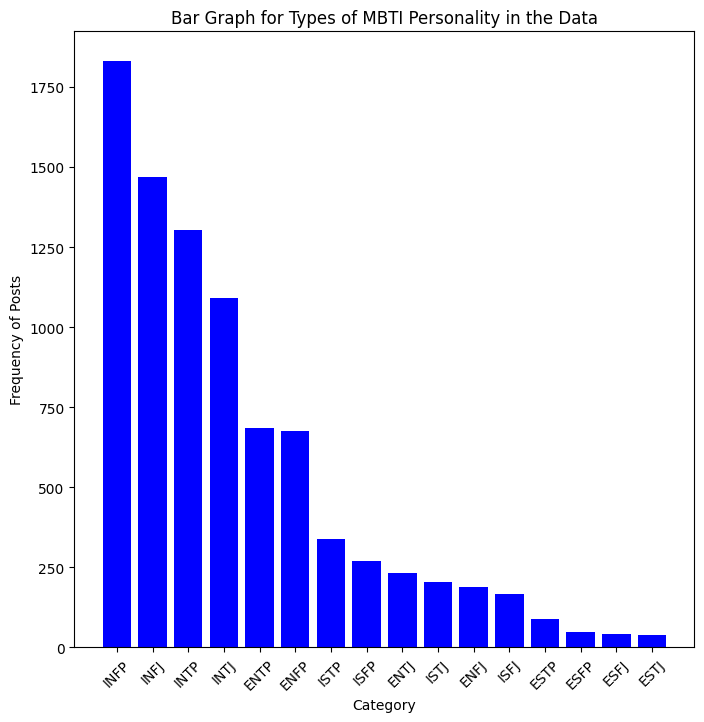

In [2]:
import matplotlib.pyplot as plt

# Plotting frequency of different categories
countCategory = df['type'].value_counts()
print('\n')

print("Number of posts for each MBTI Personality: \n",countCategory)

# Bar Graph
plt.figure(figsize=(8, 8))
plt.bar(countCategory.index, countCategory.values, color='blue')
plt.xlabel('Category')
plt.ylabel('Frequency of Posts')
plt.title('Bar Graph for Types of MBTI Personality in the Data')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.show()

# Preprocessing

In [ ]:
import nltk
import re 
import string

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Optional: List of MBTI types to remove from posts
mbti_types = [
    'INFJ','INFP','INTJ','INTP','ISFJ','ISFP','ISTJ','ISTP',
    'ENFJ','ENFP','ENTJ','ENTP','ESFJ','ESFP','ESTJ','ESTP'
]

def clean_text(text):
    # Lowercase text
    text = text.lower()

    # Removing MBTI types
    for mbti in mbti_types:
        text = re.sub(mbti.lower(), '', text)
    # Removing URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Removing punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] #this is list comprehension 
    return ' '.join(tokens)


df['clean_posts'] = df['posts'].apply(clean_text)

# View cleaned data
df[['type', 'clean_posts']].head()


,type,clean_posts
0,INFJ,moment sportscenter top ten play prankswhat li...
1,ENTP,im finding lack post alarmingsex boring positi...
2,INTP,good one course say know thats blessing cursed...
3,INTJ,dear enjoyed conversation day esoteric gabbing...
4,ENTJ,youre firedthats another silly misconception a...


In [4]:
# Create 4 binary labels
df['IE'] = df['type'].apply(lambda x: 1 if x[0] == 'I' else 0)  # 1 = I, 0 = E
df['NS'] = df['type'].apply(lambda x: 1 if x[1] == 'N' else 0)  # 1 = N, 0 = S
df['TF'] = df['type'].apply(lambda x: 1 if x[2] == 'T' else 0)  # 1 = T, 0 = F
df['JP'] = df['type'].apply(lambda x: 1 if x[3] == 'J' else 0)  # 1 = J, 0 = P

print(df[['type', 'IE', 'NS', 'TF', 'JP']].head())

   type  IE  NS  TF  JP
0  INFJ   1   1   0   1
1  ENTP   0   1   1   0
2  INTP   1   1   1   0
3  INTJ   1   1   1   1
4  ENTJ   0   1   1   1


In [5]:
# Emoji pattern
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # Transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # Flags
                           u"\U00002700-\U000027BF"  # Dingbats
                           u"\U000024C2-\U0001F251"  # Enclosed characters
                           "]+", flags=re.UNICODE)

# Check how many posts contain emojis
emoji_counts = df['posts'].apply(lambda x: bool(emoji_pattern.search(x)))
print("Posts with emojis:", emoji_counts.sum())
# Optionally view few examples
df[emoji_counts].head(3)['posts']

Posts with emojis: 215


6     'No, I can't draw on my own nails (haha). Thos...
83    'Bump|||Escobar and Co.  Escobar- ENTJ Gustavo...
88    'Newton's Universal Gravity Law. I mean seriou...
Name: posts, dtype: object

In [8]:
df.to_csv('mbti_preprocessed.csv', index=False)

## Feature Extraction

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os

In [11]:
def extract_tfidf_features(df, text_column='clean_posts', max_features=5000):
    
    print(f"Extracting TF-IDF features from {len(df)} documents...")
    print(f"Using column: {text_column}")
    
    
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),  # Unigrams and bigrams
        min_df=2,            # Ignore terms that appear in less than 2 documents
        max_df=0.95,         # Ignore terms that appear in more than 95% of documents
        stop_words='english' # Additional stopword filtering
    )
    
    # Fit and transform the cleaned text
    print("Fitting TF-IDF vectorizer...")
    tfidf_matrix = vectorizer.fit_transform(df[text_column])
    feature_names = vectorizer.get_feature_names_out().tolist()
    
    print(f"✅ Extracted {len(feature_names)} TF-IDF features")
    print(f"📊 Feature matrix shape: {tfidf_matrix.shape}")
    
    # Convert to DataFrame
    print("Converting to DataFrame...")
    feature_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    # Add your existing labels and metadata
    feature_df['type'] = df['type'].values
    feature_df['IE'] = df['IE'].values
    feature_df['NS'] = df['NS'].values
    feature_df['TF'] = df['TF'].values
    feature_df['JP'] = df['JP'].values
    
    # Optionally add original posts for reference
    feature_df['original_posts'] = df['posts'].values
    feature_df['clean_posts'] = df['clean_posts'].values
    
    return feature_df, vectorizer

In [12]:
def main():
    """Main function for TF-IDF feature extraction"""
    
    # Configuration
    CSV_PATH = r'mbti_preprocessed.csv'
    OUTPUT_FILE = 'mbti_tfidf_features.csv'
    VECTORIZER_FILE = 'tfidf_vectorizer.pkl'
    MAX_FEATURES = 5000
    
    try:
        # Load your preprocessed data
        print("🔄 Loading preprocessed data...")
        df = pd.read_csv(CSV_PATH)
        print(f"📊 Data shape: {df.shape}")
        
        # Check if you have the required columns
        required_columns = ['posts', 'type', 'clean_posts', 'IE', 'NS', 'TF', 'JP']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"❌ Missing columns: {missing_columns}")
            print(f"Available columns: {df.columns.tolist()}")
            return
        
        # If clean_posts doesn't exist, run preprocessing first
        if 'clean_posts' not in df.columns:
            print("❌ 'clean_posts' column not found. Please run preprocessing first.")
            return
        
        # Extract TF-IDF features
        print("🔄 Starting TF-IDF feature extraction...")
        df = df.fillna('')
        feature_df, vectorizer = extract_tfidf_features(
            df, 
            text_column='clean_posts',
            max_features=MAX_FEATURES
        )
        
        # Save features
        print(f"💾 Saving features to {OUTPUT_FILE}...")
        feature_df.to_csv(OUTPUT_FILE, index=False)
        
        # Save vectorizer for future use
        print(f"💾 Saving vectorizer to {VECTORIZER_FILE}...")
        with open(VECTORIZER_FILE, 'wb') as f:
            pickle.dump(vectorizer, f)
        
        # Display summary
        print(f"\n✅ Feature extraction completed successfully!")
        print(f"📁 Features saved to: {OUTPUT_FILE}")
        print(f"📁 Vectorizer saved to: {VECTORIZER_FILE}")
        print(f"📊 Total features: {len(feature_df.columns)}")
        
        # Feature breakdown
        tfidf_features = [col for col in feature_df.columns if col not in ['type', 'IE', 'NS', 'TF', 'JP', 'original_posts', 'clean_posts']]
        print(f"📊 TF-IDF features: {len(tfidf_features)}")
        print(f"📊 Label columns: 5 (type, IE, NS, TF, JP)")
        print(f"📊 Text columns: 2 (original_posts, clean_posts)")
        
        # Show first few feature names
        print(f"\n🔍 Sample TF-IDF features:")
        for i, feature in enumerate(tfidf_features[:10]):
            print(f"  {i+1}. {feature}")
        
        # Show data preview
        print(f"\n👀 Data preview:")
        print(feature_df[['type', 'IE', 'NS', 'TF', 'JP'] + tfidf_features[:5]].head())
        
    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

🔄 Loading preprocessed data...
📊 Data shape: (8675, 7)
🔄 Starting TF-IDF feature extraction...
Extracting TF-IDF features from 8675 documents...
Using column: clean_posts
Fitting TF-IDF vectorizer...
✅ Extracted 5000 TF-IDF features
📊 Feature matrix shape: (8675, 5000)
Converting to DataFrame...
💾 Saving features to mbti_tfidf_features.csv...
💾 Saving vectorizer to tfidf_vectorizer.pkl...

✅ Feature extraction completed successfully!
📁 Features saved to: mbti_tfidf_features.csv
📁 Vectorizer saved to: tfidf_vectorizer.pkl
📊 Total features: 5006
📊 TF-IDF features: 4999
📊 Label columns: 5 (type, IE, NS, TF, JP)
📊 Text columns: 2 (original_posts, clean_posts)

🔍 Sample TF-IDF features:
  1. ability
  2. able
  3. abouti
  4. absolute
  5. absolutely
  6. absolutely love
  7. absorbed
  8. abstract
  9. absurd
  10. abuse

👀 Data preview:
   type  IE  NS  TF  JP   ability      able  abouti  absolute  absolutely
0  INFJ   1   1   0   1  0.000000  0.000000     0.0   0.00000    0.000000
1  ENT

# Model Training



In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle

df = pd.read_csv('mbti_tfidf_features.csv', low_memory=False)
feature_cols = [col for col in df.columns if col not in ['type', 'IE', 'NS', 'TF', 'JP', 'original_posts', 'clean_posts']]
X = df[feature_cols]
y = df['IE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2f}")
print(f"Recall:    {recall_score(y_test, y_pred, zero_division=0):.2f}")
print(f"F1-score:  {f1_score(y_test, y_pred, zero_division=0):.2f}")

with open('best_random_forest_IE.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
